In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from google.colab import drive
drive.mount('/content/drive')
data_directory = '/content/drive/My Drive/data'
all_files = [os.path.join(data_directory, f) for f in os.listdir(data_directory) if f.endswith('.txt')]

all_data = []
for file_path in all_files:
    data = []
    hist = []
    with open(file_path, 'r') as file:
        skip_header = True
        for line in file:
            if skip_header:
                skip_header = False
                continue
            parts = line.split()
            if len(parts) == 3:
                if hist:
                    data.append(hist)
                hist = [int(x) for x in parts]
            else:
                hist.extend(map(int, parts))
    if hist:
        data.append(hist)

    cols = ['year', 'day', 'hour'] + [f'bin_{i+1}' for i in range(60)]
    df = pd.DataFrame(data, columns=cols)
    all_data.append(df)

full_data = pd.concat(all_data, ignore_index=True)

he3_start = int((2.7 - 2) / 0.05)
he3_end = int((3.3 - 2) / 0.05)
he4_start = int((3.7 - 2) / 0.05)
he4_end = int((4.3 - 2) / 0.05)
full_data['He-3'] = full_data.iloc[:, 3+he3_start:3+he3_end+1].sum(axis=1)
full_data['He-4'] = full_data.iloc[:, 3+he4_start:3+he4_end+1].sum(axis=1)
full_data['He-3 Rich'] = ((full_data['He-3'] >= 0.5 * full_data['He-4']) & ((full_data['He-3'] + full_data['He-4']) >= 20)).astype(int)

X = full_data[['He-3', 'He-4']]
y = full_data['He-3 Rich']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(10, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=30, validation_split=0.2)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9511 - loss: 0.1829 - val_accuracy: 0.9992 - val_loss: 0.0021
Epoch 2/30
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9995 - loss: 0.0016 - val_accuracy: 0.9993 - val_loss: 0.0017
Epoch 3/30
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9995 - loss: 0.0012 - val_accuracy: 0.9993 - val_loss: 0.0014
Epoch 4/30
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 0.9995 - val_loss: 0.0011
Epoch 5/30
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9997 - loss: 8.0448e-04 - val_accuracy: 0.9996 - val_loss: 9.1872e-04
Epoch 6/30
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9998 - loss: 6.3997e-04 - val_accuracy: 0.9997 - val_loss: 7.5938e-04
Epoch 7/30
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9998 - loss: 5.2659e-04 - val_accuracy: 0.9998 - val_loss: 6.6499e-04
Epoch 8/30
2586/2586 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy:

In [3]:
print(f"Test Accuracy: {test_acc:.4f}")
y_pred = model.predict(X_test_scaled) > 0.5
print(classification_report(y_test, y_pred, target_names=['Non-Rich', 'He-3 Rich']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
roc_auc = roc_auc_score(y_test, model.predict(X_test_scaled))
print(f"ROC-AUC Score: {roc_auc:.4f}")

Test Accuracy: 0.9999
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
              precision    recall  f1-score   support

    Non-Rich       1.00      1.00      1.00     44210
   He-3 Rich       0.96      1.00      0.98       114

    accuracy                           1.00     44324
   macro avg       0.98      1.00      0.99     44324
weighted avg       1.00      1.00      1.00     44324

Confusion Matrix:
[[44205     5]
 [    0   114]]
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
ROC-AUC Score: 1.0000


1386/1386 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


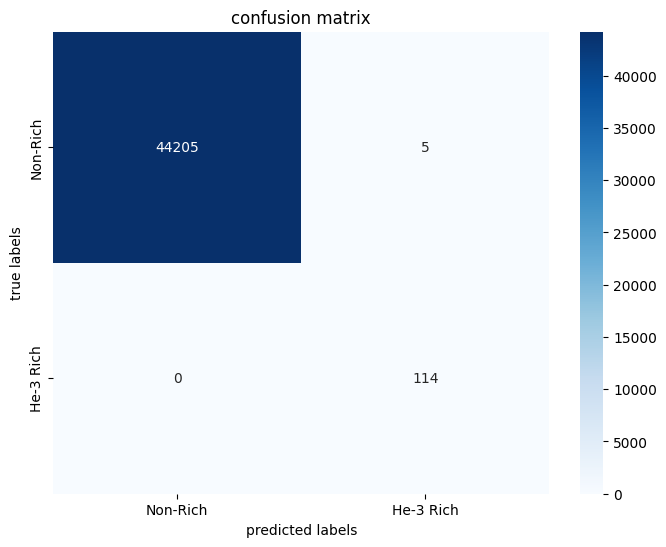

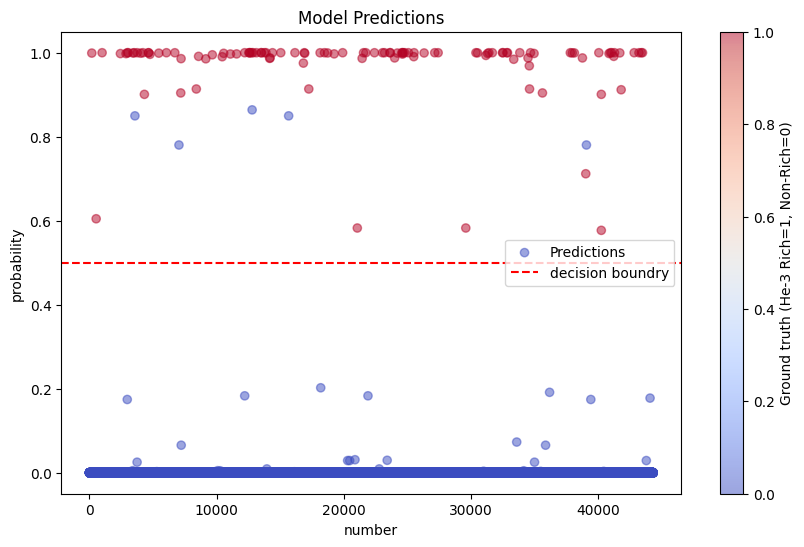

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

y_pred = model.predict(X_test_scaled)
y_pred_class = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Rich', 'He-3 Rich'], yticklabels=['Non-Rich', 'He-3 Rich'])
plt.xlabel('predicted labels')
plt.ylabel('true labels')
plt.title('confusion matrix')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_pred, c=y_test, cmap='coolwarm', alpha=0.5, marker='o', label='Predictions')
plt.colorbar(label='Ground truth (He-3 Rich=1, Non-Rich=0)')
plt.xlabel('number')
plt.ylabel('probability')
plt.title('Model Predictions')
plt.axhline(0.5, color='red', linestyle='--', label='decision boundry')
plt.legend()
plt.show()
